# Lesson 1 - PETS

## Pets and the High level API

In [2]:
from fastai.basics import *
from fastai.vision.all import *
from fastai.callback.all import *


In [3]:
import numpy as np
from fastcore.xtras import Path # @patch'd properties to the Pathlib module

from fastai.callback.fp16 import to_fp16
from fastai.callback.schedule import fit_one_cycle, lr_find 

from fastai.data.block import CategoryBlock, DataBlock
from fastai.data.external import untar_data, URLs
from fastai.data.transforms import get_image_files, Normalize, RandomSplitter, RegexLabeller

from fastai.interpret import ClassificationInterpretation
from fastai.learner import Learner # imports @patch'd properties to Learner including `save`, `load`, `freeze`, and `unfreeze`

from fastai.metrics import error_rate

from fastai.vision.augment import aug_transforms, RandomResizedCrop
from fastai.vision.core import imagenet_stats
from fastai.vision.data import ImageDataLoaders, ImageBlock
from fastai.vision.learner import cnn_learner

from torchvision.models.resnet import resnet34, resnet50


In [4]:
path = untar_data(URLs.PETS)


In [6]:
path.ls()

(#2) [Path('C:/Users/Minty/.fastai/data/oxford-iiit-pet/annotations'),Path('C:/Users/Minty/.fastai/data/oxford-iiit-pet/images')]

In [8]:
path = untar_data(URLs.PETS)
fnames = get_image_files(path/'images')            # get_image_files recursively returns path file/
                                                   # on the path specified (returns a path)
pat = r'(.+)_\d+.jpg$'



In [9]:
fnames # Path files recursively returned

(#7390) [Path('C:/Users/Minty/.fastai/data/oxford-iiit-pet/images/Abyssinian_1.jpg'),Path('C:/Users/Minty/.fastai/data/oxford-iiit-pet/images/Abyssinian_10.jpg'),Path('C:/Users/Minty/.fastai/data/oxford-iiit-pet/images/Abyssinian_100.jpg'),Path('C:/Users/Minty/.fastai/data/oxford-iiit-pet/images/Abyssinian_101.jpg'),Path('C:/Users/Minty/.fastai/data/oxford-iiit-pet/images/Abyssinian_102.jpg'),Path('C:/Users/Minty/.fastai/data/oxford-iiit-pet/images/Abyssinian_103.jpg'),Path('C:/Users/Minty/.fastai/data/oxford-iiit-pet/images/Abyssinian_104.jpg'),Path('C:/Users/Minty/.fastai/data/oxford-iiit-pet/images/Abyssinian_105.jpg'),Path('C:/Users/Minty/.fastai/data/oxford-iiit-pet/images/Abyssinian_106.jpg'),Path('C:/Users/Minty/.fastai/data/oxford-iiit-pet/images/Abyssinian_107.jpg')...]

### Building DataLoaders

Must specify
- Path (location of objects)
- any image transforms (***makes images same size***) and augmentations (***batch transforms done on GPU***)

` item_tfms = RandomResizedCrop(460, min_scale=0.75, ratio=(1.,1.))
batch_tfms = [*aug_transforms(size=224, max_warp=0), Normalize.from_stats(*imagenet_stats)]
bs=64`



In [10]:
item_tfms = RandomResizedCrop(460, min_scale=0.75, ratio=(1.,1.))
batch_tfms = [*aug_transforms(size=224, max_warp=0), Normalize.from_stats(*imagenet_stats)]
bs=64

In [11]:
 pets = DataBlock(blocks=(ImageBlock, CategoryBlock),           # Blocks
                 get_items=get_image_files,                     # Image file locations
                 splitter=RandomSplitter(),                     # Random splitter
                 get_y=RegexLabeller(pat = r'/([^/]+)_\d+.*'),  # label (get_y) 
                 item_tfms=item_tfms,
                 batch_tfms=batch_tfms)

Datablock runs through get_items -> returns a path file.
- Here it would imply that get_items = get_image_files, that the path itself has all the information
- data for get_y is regex label on the path file itself

Contrast method used in multicat FastAi

`df = pd.read_csv(path/'train.csv')
df.head()`


In [17]:
path = untar_data(URLs.PASCAL_2007)

df = pd.read_csv(path/'train.csv')
df.head()


,fname,labels,is_valid
0,000005.jpg,chair,True
1,000007.jpg,car,True
2,000009.jpg,horse person,True
3,000012.jpg,car,False
4,000016.jpg,bicycle,True


In [16]:
path.ls()

(#8) [Path('C:/Users/Minty/.fastai/data/pascal_2007/segmentation'),Path('C:/Users/Minty/.fastai/data/pascal_2007/test'),Path('C:/Users/Minty/.fastai/data/pascal_2007/test.csv'),Path('C:/Users/Minty/.fastai/data/pascal_2007/test.json'),Path('C:/Users/Minty/.fastai/data/pascal_2007/train'),Path('C:/Users/Minty/.fastai/data/pascal_2007/train.csv'),Path('C:/Users/Minty/.fastai/data/pascal_2007/train.json'),Path('C:/Users/Minty/.fastai/data/pascal_2007/valid.json')]

In [18]:
(path/'train').ls()

(#5012) [Path('C:/Users/Minty/.fastai/data/pascal_2007/train/000005.jpg'),Path('C:/Users/Minty/.fastai/data/pascal_2007/train/000007.jpg'),Path('C:/Users/Minty/.fastai/data/pascal_2007/train/000009.jpg'),Path('C:/Users/Minty/.fastai/data/pascal_2007/train/000012.jpg'),Path('C:/Users/Minty/.fastai/data/pascal_2007/train/000016.jpg'),Path('C:/Users/Minty/.fastai/data/pascal_2007/train/000017.jpg'),Path('C:/Users/Minty/.fastai/data/pascal_2007/train/000019.jpg'),Path('C:/Users/Minty/.fastai/data/pascal_2007/train/000020.jpg'),Path('C:/Users/Minty/.fastai/data/pascal_2007/train/000021.jpg'),Path('C:/Users/Minty/.fastai/data/pascal_2007/train/000023.jpg')...]

Here a CSV identifies labelling, separate to the image files, the method would be

**Define method of getting the image files and labelling (via CSV)**

`def get_x(r): 
    return path/'train'/r['fname']
def get_y(r): 
    return r['labels'].split(' ')`

**Then pass this into a datablock**

`dblock = DataBlock(blocks=(ImageBlock, MultiCategoryBlock),
                   splitter=splitter,
                   get_x=get_x, 
                   get_y=get_y,
                   item_tfms = RandomResizedCrop(128, min_scale=0.35))
dls = dblock.dataloaders(df)`

### Back to Pets

In [21]:
path = untar_data(URLs.PETS)
path.ls()

(#2) [Path('C:/Users/Minty/.fastai/data/oxford-iiit-pet/annotations'),Path('C:/Users/Minty/.fastai/data/oxford-iiit-pet/images')]

In [19]:
 pets = DataBlock(blocks=(ImageBlock, CategoryBlock),           # Blocks
                 get_items=get_image_files,                     # Image file locations
                 splitter=RandomSplitter(),                     # Random splitter
                 get_y=RegexLabeller(pat = r'/([^/]+)_\d+.*'),  # label (get_y) 
                 item_tfms=item_tfms,
                 batch_tfms=batch_tfms)

In [24]:
path_im = path/'images'
dls= pets.dataloaders(path_im, bs=bs)

Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck


In [30]:
a,b = dls.one_batch()
a.shape, b.shape         # standard batch size is 64


(torch.Size([64, 3, 224, 224]), torch.Size([64]))

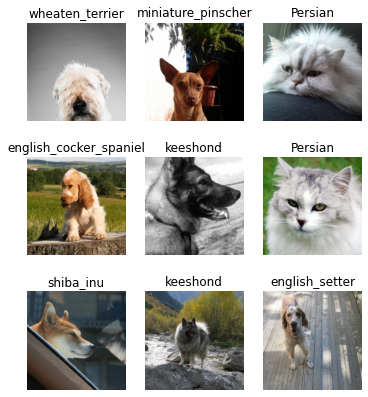

In [31]:
dls.show_batch(max_n=9, figsize=(6,7))

In [34]:
# Finding vocab

dls.vocab, dls.vocab.o2i

(['Abyssinian', 'Bengal', 'Birman', 'Bombay', 'British_Shorthair', 'Egyptian_Mau', 'Maine_Coon', 'Persian', 'Ragdoll', 'Russian_Blue', 'Siamese', 'Sphynx', 'american_bulldog', 'american_pit_bull_terrier', 'basset_hound', 'beagle', 'boxer', 'chihuahua', 'english_cocker_spaniel', 'english_setter', 'german_shorthaired', 'great_pyrenees', 'havanese', 'japanese_chin', 'keeshond', 'leonberger', 'miniature_pinscher', 'newfoundland', 'pomeranian', 'pug', 'saint_bernard', 'samoyed', 'scottish_terrier', 'shiba_inu', 'staffordshire_bull_terrier', 'wheaten_terrier', 'yorkshire_terrier'],
 {'Abyssinian': 0,
  'Bengal': 1,
  'Birman': 2,
  'Bombay': 3,
  'British_Shorthair': 4,
  'Egyptian_Mau': 5,
  'Maine_Coon': 6,
  'Persian': 7,
  'Ragdoll': 8,
  'Russian_Blue': 9,
  'Siamese': 10,
  'Sphynx': 11,
  'american_bulldog': 12,
  'american_pit_bull_terrier': 13,
  'basset_hound': 14,
  'beagle': 15,
  'boxer': 16,
  'chihuahua': 17,
  'english_cocker_spaniel': 18,
  'english_setter': 19,
  'german_sh

### Creating learner

` pets = DataBlock(blocks=(ImageBlock, CategoryBlock),           # Blocks
                 get_items=get_image_files,                     # Image file locations
                 splitter=RandomSplitter(),                     # Random splitter
                 get_y=RegexLabeller(pat = r'/([^/]+)_\d+.*'),  # label (get_y) 
                 item_tfms=item_tfms,
                 batch_tfms=batch_tfms)
                 `

`path_im = path/'images'
dls= pets.dataloaders(path_im, bs=bs)`

In [39]:
learn = cnn_learner(dls, resnet34, pretrained=True, metrics=error_rate).to_fp16()

In [40]:
learn.fit_one_cycle(1)

C:\Users\Minty\miniconda3\lib\site-packages\torch\cuda\amp\grad_scaler.py:115: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn("torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.")


epoch,train_loss,valid_loss,error_rate,time
0,1.181701,0.337334,0.112314,18:53


In [41]:
learn.save('stage_1')

Path('models/stage_1.pth')

### Proper way of selecting a learning rate

`learn = cnn_learner(dls, resnet34, pretrained=True, metrics=error_rate).to_fp16()`

1. learn.fit_one_cycle(4) ----> Example: Fit for 4 epochs
(Can save and load as: learn.save('stage_1') ; learn.load('stage_1'))

2. learn.lr_find() ----> Select LR between trough
    
3. learn.unfreeze() -----> all layers can be modified

4. learn.fit_one_cycle(4, lr_max=slice(1e-6, 1e-4))


> And then can compare learn.fit_one_cycle(4) -> unfreeze -> into another learn.fit_one_cycle(4)
against
learn.fit_one_cycle(4) -> lr.find -> unfreeze -> learn.fit_one_cycle(lr_max = ...)


### Repeat with resnet50 example

In [ ]:

# Define DataBlock
pets = DataBlock(blocks=(ImageBlock, CategoryBlock),
                 get_items=get_image_files,
                 splitter=RandomSplitter(),
                 get_y=RegexLabeller(pat = r'/([^/]+)_\d+.*'),
                 item_tfms=item_tfms,
                 batch_tfms=batch_tfms)

#Datablock -> DataLoaders
dls = pets.dataloaders(untar_data(URLs.PETS)/"images", bs=32)

#Define Learner
learn = cnn_learner(data, resnet50, pretrained=True, metrics=error_rate)

#Find Learning Rate
learn.lr_find()

#Initial Learning
learn.fit_one_cycle(5, lr_max=slice(3e-4, 3e-3))

# Continue Learning
learn.unfreeze()
learn.fit_one_cycle(2, max_lr=4e-4)